# Curve Extraction and Filtering

## Pulling out Data from the Spreadsheets

In [1]:
from __future__ import division, print_function

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

We are interested in the following metrics:
 - LV: time of end systole.
 - LV: time and magnitude of peak systolic emptying
 - LV: time and magnitude of peak diastolic filling rate
 - LV: time and magnitude of secondary filling (if possible)
 - LV: 80% refilling time both in ms and as fraction of diastolic time
 - LA: time and magnitude of max filling rate
 - LA: time and magnitude of early max emptying rate
 - LA: time and magnitude of late max emptying rate (if possible)

Final dataframe should be tidy (indexed by patient, columns are parameters). 

In [2]:
volumes = 'FullVolumes.xlsx'
rrintervals = 'RRIntervals.xlsx'

df_vols = pd.read_excel(volumes)
df_rrintervals = pd.read_excel(rrintervals).reset_index(drop=True)
df_rrintervals.index = ['RR']

df_la = df_vols.filter(regex='LA-[0-9]{3,3}$')
df_lv = df_vols.filter(regex='LV-[0-9]{3,3}$')
df_times = df_rrintervals.filter(regex='LV-[0-9]{3,3}$').T

In [3]:
df_lv.head()

,LV-178,LV-179,LV-182,LV-183,LV-186,LV-187,LV-188,LV-191,LV-192,LV-198,...,LV-278,LV-282,LV-283,LV-287,LV-289,LV-290,LV-293,LV-300,LV-309,LV-329
0,160,189.66,170,93,172,127.90,150,126,103.98,116,...,78,193,146,153,204,230,106,125,126,193
1,160,186.28,168,93,176,124.26,150,125,94.15,114,...,81,188,150,148,189,221,109,133,117,192
2,149,178.96,158,84,164,116.90,144,113,75.06,108,...,72,175,146,123,153,217,106,134,107,183
3,125,152.12,138,71,148,94.70,137,100,58.17,90,...,66,148,140,91,122,197,97,121,92,175
4,108,126.21,119,56,133,81.39,117,88,42.88,81,...,56,112,125,67,105,160,84,96,74,155


In [4]:
df_times.head()

,RR
LV-178,674.157303
LV-179,845.070423
LV-182,952.380952
LV-183,821.917808
LV-186,983.606557


This gets a lttle messy. Once we multiply by the rr interval then the time base is no longer constant across subjects. We could maybe work in phases and rescale to the cardiac cycle afterwards or we could handle each subject separately.

In [5]:
nrows = df_la.count(axis=0)[0]
assert all(df_la.count(axis=0) == nrows)

df_times['dT'] = df_times['RR'] / nrows
df_times.head()

,RR,dT
LV-178,674.157303,26.966292
LV-179,845.070423,33.802817
LV-182,952.380952,38.095238
LV-183,821.917808,32.876712
LV-186,983.606557,39.344262


In [6]:
patnos = [int(col[-3:]) for col in df_la]
len(patnos)

43

We can pack the data into a dictionary of data frames indexed by patient with columns for LV and LA volumes.

In [7]:
patients = {}
for patno in patnos:
    patients[patno] = pd.concat([
        pd.Series(np.arange(nrows) * df_times['dT']['LV-%d' % patno], name='Time'),
        df_lv['LV-%d' % patno],
        df_la['LA-%d' % patno],
    ], axis=1).set_index('Time')
    patients[patno].columns = ('LV', 'LA')
    patients[patno].pat_name = 'Patient %d' % patno
len(patients)

43

In [8]:
patients[178].head()

,LV,LA
Time,,
0.000000,160,29
26.966292,160,31
53.932584,149,32
80.898876,125,40
107.865169,108,42


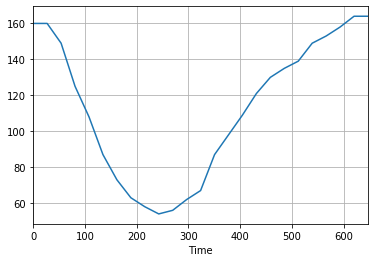

In [9]:
lv_volume_series = patients[178]['LV']
lv_volume_series.plot()
plt.grid(True);

We need to apply some filtering - we can compare Savitzy-Golay filtering or loess fitting. 

### Savitzky-Golay Filtering

In [10]:
from scipy.signal import savgol_filter

def plot_vols_sav_gol(patient, region):

    units, time_units = 'ml', 'ms'
    patient_name = patient.pat_name
    
    volume_series = patient[region]
    time = np.asarray(volume_series.index)
    volume = np.asarray(volume_series.values)    
    r_to_r = time[-1]
    
    sg_volume     = savgol_filter(x=volume, window_length=5, polyorder=2, mode='interp')
    dt_secs       = np.mean(np.diff(time)) / 1000
    derivative    = np.gradient(volume, dt_secs)
    sg_derivative = savgol_filter(x=volume, window_length=5, polyorder=2, deriv=1, delta=dt_secs)

    min_volume    = np.amin(sg_volume)
    max_volume    = np.mean([np.amax(sg_volume[:5]), np.amax(sg_volume[-5:])])
    max_gradient  = np.amax(sg_derivative)

    min_vol_time  = time[np.argmin(sg_volume)]

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0].plot(time, volume, '.')
    ax[0].plot(time, sg_volume, '-')
    ax[0].grid(True)
    ax[0].set_xlabel('Delay from Trigger (%s)' % time_units)
    ax[0].set_ylabel('Volume (%s)' % units)
    ax[0].text(500, 50, 'RR interval %3.0f ms' % r_to_r)
    ax[0].axhline(y=min_volume, linestyle='-.')
    ax[0].axvline(x=min_vol_time, linestyle='-.')
    ax[0].set_title('Volume')

    ax[1].plot(time, derivative, '.')
    ax[1].plot(time, sg_derivative, '-')
    ax[1].grid(True)
    ax[1].set_xlabel('Delay from Trigger (%s)' % time_units)
    ax[1].set_ylabel('Gradient (%s/sec)' % units)
    ax[1].text(500, -200, 'RR interval %3.0f ms' % r_to_r)
    ax[1].axvline(x=min_vol_time, linestyle='-.')
    ax[1].set_title('Gradient')

    fig.suptitle('%s (%s Volume)' % (patient_name, region), fontsize=14)

    plt.show()

    print('Minimum Volume                   = %4.0f ml'     % min_volume)
    print('Maximum Volume Estimate          = %4.0f ml'     % max_volume)
    print('Maximum Rate of change of Volume = %4.0f ml/sec' % max_gradient)


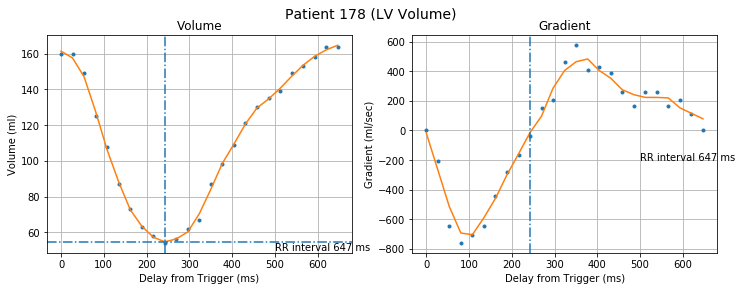

Minimum Volume                   =   55 ml
Maximum Volume Estimate          =  163 ml
Maximum Rate of change of Volume =  482 ml/sec


In [11]:
plot_vols_sav_gol(patient=patients[178], region='LV')

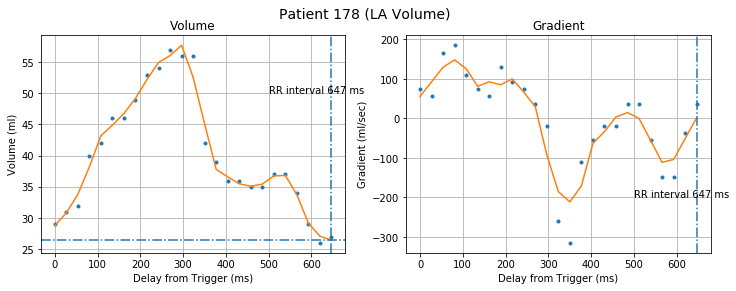

Minimum Volume                   =   26 ml
Maximum Volume Estimate          =   40 ml
Maximum Rate of change of Volume =  148 ml/sec


In [12]:
plot_vols_sav_gol(patient=patients[178], region='LA')

Note the LA curves the senses will be reversed - we want to find the maximum etc.
Also, if we use a Savitzky-Golay filter we really want to get the gradient directly from the fit - the unsmoothed discrete differences won't be very meaningful due to the large noise amplification.

### Lowess Filtering

In [13]:
from statsmodels.nonparametric.smoothers_lowess import lowess

def plot_vols_lowess(patient, region):

    units, time_units = 'ml', 'ms'
    patient_name = patient.pat_name
    
    volume_series = patient[region]
    time = np.asarray(volume_series.index)
    volume = np.asarray(volume_series.values) 
    dt_secs = np.mean(np.diff(time)) / 1000
    r_to_r = time[-1]
    lowess_volume     = lowess(volume, time, frac=0.2).T[1]
    derivative        = np.gradient(volume, dt_secs)
    lowess_derivative = np.gradient(lowess_volume, dt_secs)

    min_volume    = np.amin(lowess_volume)
    max_volume    = np.mean([np.amax(lowess_volume[:5]), np.amax(lowess_volume[-5:])])
    max_gradient  = np.amax(lowess_derivative)

    min_vol_time  = time[np.argmin(lowess_volume)]


    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0].plot(time, volume, '.')
    ax[0].plot(time, lowess_volume, '-')
    ax[0].grid(True)
    ax[0].set_xlabel('Delay from Trigger (%s)' % time_units)
    ax[0].set_ylabel('Volume (%s)' % units)
    ax[0].text(500, 50, 'RR interval %3.0f ms' % r_to_r)
    ax[0].axhline(y=min_volume, linestyle='-.')
    ax[0].axvline(x=min_vol_time, linestyle='-.')
    ax[0].set_title('Volume')

    ax[1].plot(time, derivative, '.')
    ax[1].plot(time, lowess_derivative, '-')
    ax[1].grid(True)
    ax[1].set_xlabel('Delay from Trigger (%s)' % time_units)
    ax[1].set_ylabel('Gradient (%s/sec)' % units)
    ax[1].text(500, -200, 'RR interval %3.0f ms' % r_to_r)
    ax[1].axvline(x=min_vol_time, linestyle='-.')

    fig.suptitle('%s (LV %s Volume)' % (patient_name, region), fontsize=14)

    plt.show()

    print('Minimum Volume                   = %4.0f ml'     % min_volume)
    print('Maximum Volume Estimate          = %4.0f ml'     % max_volume)
    print('Maximum Rate of change of Volume = %4.0f ml/sec' % max_gradient)

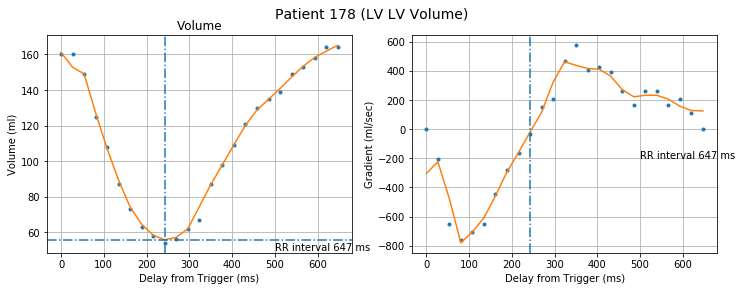

Minimum Volume                   =   56 ml
Maximum Volume Estimate          =  163 ml
Maximum Rate of change of Volume =  462 ml/sec


In [14]:
plot_vols_lowess(patient=patients[178], region='LV')

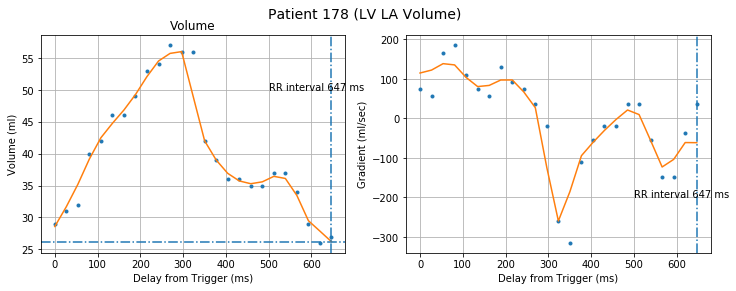

Minimum Volume                   =   26 ml
Maximum Volume Estimate          =   39 ml
Maximum Rate of change of Volume =  139 ml/sec


In [15]:
plot_vols_lowess(patient=patients[178], region='LA')

-----

We'll go with the S-G filtering as this seems to produce a cleaner derivative. For the identification of features in the curve we'll do some additional interpolation in the smooth SG curve. The problem with lowess derivative is that we are just taking a finite difference rather than fitting a smooth curve. With S-G we can extract a smooth derivative directly but on the other hand we don't get the outlier rejection of loess. Ultimately, it depends on whether the non-smoothness in the curves is random noise/jitter or contammination with outliers.

-----

In [16]:
from scipy.interpolate import InterpolatedUnivariateSpline

def plot_la_params(patient, region='LA'):
    units, time_units = 'ml', 'ms'
    patient_name = patient.pat_name
    
    volume_series = patient[region]
    time = np.asarray(volume_series.index)
    volume = np.asarray(volume_series.values) 

    r_to_r = time[-1]

    sg_volume     = savgol_filter(x=volume, window_length=5, polyorder=2, mode='interp')
    dt_secs       = np.mean(np.diff(time)) / 1000
    derivative    = np.gradient(volume, dt_secs)
    sg_derivative = savgol_filter(x=volume, window_length=5, polyorder=2, deriv=1, delta=dt_secs)    
    
    spline = InterpolatedUnivariateSpline(time, sg_volume)

    interpolated_time   = np.linspace(0, time[-1], len(time)*3)
    interpolated_savgol = spline(interpolated_time)

    max_volume    = np.amax(interpolated_savgol)
    min_volume    = np.mean([np.amin(interpolated_savgol[:15]), np.amin(interpolated_savgol[-15:])])
    max_vol_time  = interpolated_time[np.argmax(interpolated_savgol)]

    def find_idx_nearest(array, value):
        return np.abs(array-value).argmin()

    fig, ax = plt.subplots(1, 1, figsize=(9, 6))
    ax.plot(time, volume, '.')
    ax.plot(interpolated_time, interpolated_savgol, '-')
    ax.grid(True)
    ax.set_xlabel('Delay from Trigger (%s)' % time_units)
    ax.set_ylabel('Volume (%s)' % units)
    ax.text(500, 60, 'RR interval %3.0f ms' % r_to_r)
    ax.axhline(y=min_volume, linestyle='-.')
    ax.axhline(y=max_volume, linestyle='-.')
    ax.axhline(y=0.2*max_volume + 0.8*max_volume, linestyle='-.')
    ax.axvline(x=max_vol_time, linestyle='-.')

    fig.suptitle('%s (%s Volume)' % (patient_name, region), fontsize=14)

    plt.show()

    print('Time of max. volume = %3.0f ms' % max_vol_time)
    print('R-R interval        = %3.0f ms' % r_to_r)


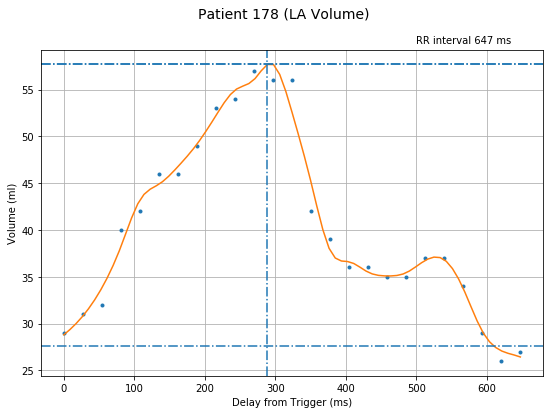

Time of max. volume = 289 ms
R-R interval        = 647 ms


In [17]:
plot_la_params(patient=patients[178])

In [18]:
def plot_lv_params(patient, region='LV'):
    units, time_units = 'ml', 'ms'
    patient_name = patient.pat_name
    
    volume_series = patient[region]
    time = np.asarray(volume_series.index)
    volume = np.asarray(volume_series.values) 

    r_to_r = time[-1]
    sg_volume     = savgol_filter(x=volume, window_length=5, polyorder=2, mode='interp')
    dt_secs       = np.mean(np.diff(time)) / 1000
    derivative    = np.gradient(volume, dt_secs)
    sg_derivative = savgol_filter(x=volume, window_length=5, polyorder=2, deriv=1, delta=dt_secs)

    spline = InterpolatedUnivariateSpline(time, sg_volume)

    interpolated_time   = np.linspace(0, time[-1], len(time)*3)
    interpolated_savgol = spline(interpolated_time)

    min_volume    = np.amin(interpolated_savgol)
    max_volume    = np.mean([np.amax(interpolated_savgol[:10]), np.amax(interpolated_savgol[-10:])])
    min_vol_index = np.argmin(interpolated_savgol)
    min_vol_time  = interpolated_time[min_vol_index]

    def find_idx_nearest(array, value, after=0):
        return np.abs(array[after:]-value).argmin() + after

    eighty_per_cent_time = interpolated_time[
        find_idx_nearest(interpolated_savgol, 0.2*min_volume + 0.8*max_volume, after=min_vol_index)
    ]

    fig, ax = plt.subplots(1, 1, figsize=(9, 6))
    ax.plot(time, volume, '.')
    ax.plot(interpolated_time, interpolated_savgol, '-')
    ax.grid(True)
    ax.set_xlabel('Delay from Trigger (%s)' % time_units)
    ax.set_ylabel('Volume (%s)' % units)
    ax.text(500, 60, 'RR interval %3.0f ms' % r_to_r)
    ax.axhline(y=min_volume, linestyle='-.')
    ax.axhline(y=max_volume, linestyle='-.')
    ax.axhline(y=0.2*min_volume + 0.8*max_volume, linestyle='-.')
    ax.axvline(x=min_vol_time, linestyle='-.')
    ax.axvline(x=eighty_per_cent_time, linestyle='-.')

    fig.suptitle('%s (%s Volume)' % (patient_name, region), fontsize=14)

    plt.show()

    print('Time of min. volume = %3.0f ms' % min_vol_time)
    print('Time of 80%% filling = %3.0f ms' % eighty_per_cent_time)
    print('Time difference     = %3.0f ms' % (eighty_per_cent_time - min_vol_time))
    print('R-R interval        = %3.0f ms' % r_to_r)
    print('Filling time ratio  = %0.3f' % ((eighty_per_cent_time - min_vol_time)/r_to_r))

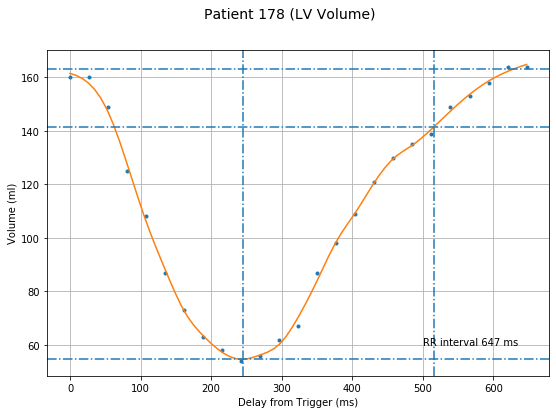

Time of min. volume = 245 ms
Time of 80% filling = 516 ms
Time difference     = 271 ms
R-R interval        = 647 ms
Filling time ratio  = 0.419


In [19]:
plot_lv_params(patient=patients[178])